### What is Quick Reserve
- It is aimed primarily for reacting to pre-fault disturbances to restore the energy imbalance quickly and return the frequency close to 50.0 Hz. It went live on the Enduring Auction Capability (EAC) platform on 19 November 2024, with the first auction taking place on 3 December 2024. [From: NESO](https://www.neso.energy/industry-information/balancing-services/reserve-services/quick-reserve#:~:text=System%20conditions%20are%20changing%2C%20and,that%20take%20pre%2Dfault%20frequency)
- It is a day-ahead auction for half-hourly settlement period. NESO conducts daily auctions at 14:00 for the Quick Reserve service, covering delivery periods from 23:00 on the auction day to 23:00 the following day. 

<p align="center">
<img src="QR_response_modo_energy.png" alt="My Image" style="width:500px; height:auto;" />
</p>
[Source: Modo Energy](https://modoenergy.com/research/gb-battery-energy-storage-quick-reserve-balancing-mechanism-launch-november-2024)

- **Positive quick reserve:** Positive quick reserve (PQR) is an upward frequency response where generators increase their output (e.g.: batteries, gas pearkers, hydro, or pumped storage raming up) or demand site assets reduce their consumption when system frequency drops. 

- **Negative quick reserve:** It is opposite of PQR where generation is decreased or demand is increase as there is excess power in the system.

Payments are made separately for availability and utilization. Availability payments is in £/MWh determined by pay-as-clear price in day-ahead auction. For utilization, units will submit bids and offers in the balancing mechanism. Those instructed to import or export power will then be paid (or have to pay) for the energy they deliver in £/MWh.These dispatches will compete with other Balancing Mechanism actions that can provide a similar response. So if a BMU that isn't contracted via Quick Reserve can balance the system at a cheaper price and with the same performance, the ESO can use it.

In this notebook, historical cleared volume and clearing prices of positive quick reserve (PQR) and negative quick reserve are analyzed. 
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import re
# import seaborn as sns
import urllib3

In [2]:
def neso_api_to_df(api: str):
    '''Fetches data from the NESO API and converts it into a Pandas DataFrame'''
    try:
        http = urllib3.PoolManager()
        request = http.request('GET', api)
        json_response = request.json() # NESO api returns data in JSON format
        listed_data = json_response['result']['records']
        df = pd.DataFrame(listed_data)
        return df
    except Exception as e:
        print(f"API request error: {e}")
        return pd.DataFrame()
    
def day_df(df: pd.DataFrame, date: str):
    '''Retuns one day data from df (with datetime index) 
    '''
    day_df = df.copy()
    day_df = day_df[day_df.index.date == pd.to_datetime(date).date()]
    return day_df

def plot_two_variable(ax, y_left_lim: list, y_right_lim: list, 
                      x_var: str, y_left_var:str, y_right_var:str, 
                      df: pd.DataFrame, y_lfet_label:str, y_right_label:str, fig_title:str,
                      x_axis_format = '%H'):
    '''Plotting two variables on y-axis with the same x-axis'''
    ax_twin = ax.twinx();

    ax.plot(x_var, y_left_var, data = df, color = 'blue', label = y_left_var.replace('_', ' ').title());
    ax.set_ylim(y_left_lim);
    ax.xaxis.set_major_formatter(mdates.DateFormatter(x_axis_format));
    ax.set_title(fig_title);
    ax.set_ylabel(y_lfet_label, color = 'blue');

    ax_twin.plot(x_var, y_right_var, data = df, color = 'red', linestyle = '--', label = y_right_var.replace('_', ' ').title());
    ax_twin.set_ylim(y_right_lim)
    ax_twin.set_ylabel(y_right_label, rotation = 270, color = 'red')


#### Data collection and processing

- EAC auction results is available at (https://www.neso.energy/data-portal/eac-auction-results). It consists of frequency response (DRL, DRH, DML, DMH, DCL, DCH) and quick reserve (PQR and NQR). 
- Response data is from November 2023 while quick reserve data is from its inception in $3^{\text{rd}}$ December (starting from auction id no: 828). The auction id is the same for all 48 settlement periods of a day.
- Frequency response and quick reserve data is splitted by choosing service types to 'Response' and 'Quick Reserve', respectively. Data, hour, minute, and settlement periods are added in quick reserve data.
- Quick reserve data is further splitted into positive quick reserve and negative quick reserve dataframes.

In [3]:
# Auction results: EAC auction (current platform for DCMR) and historical 
eac_auction_api = "https://api.neso.energy/api/3/action/datastore_search?resource_id=596f29ac-0387-4ba4-a6d3-95c243140707&limit=200000"
eac_auction_df = neso_api_to_df(eac_auction_api)

# Tidying up columns names
columns = eac_auction_df.columns.tolist()
modified_columns = [column.lstrip('_').replace('ID', 'Id') for column in columns]
modified_columns = [re.sub(r'([A-Z])', r'_\1', column).lstrip('_').lower() for column in modified_columns]
eac_auction_df.columns = modified_columns

#Converting time columns from object types to datetime
eac_auction_df.delivery_start = pd.to_datetime(eac_auction_df.delivery_start)
eac_auction_df.delivery_end = pd.to_datetime(eac_auction_df.delivery_end)

In [4]:
# Quick reserve df
quick_reserve_df = eac_auction_df[eac_auction_df.service_type == 'Quick Reserve'].copy()
quick_reserve_df.sort_values(by = 'delivery_start', inplace = True)
quick_reserve_df.set_index('delivery_start', inplace = True, drop = False)
#Adding date, hour, minutes, and settlement periods 
quick_reserve_df.loc[:, 'date'] = quick_reserve_df.index.date
quick_reserve_df.loc[:, 'hour'] = quick_reserve_df.index.hour
quick_reserve_df.loc[:, 'minute'] = quick_reserve_df.index.minute
start_time, end_time = quick_reserve_df.delivery_start.min(), quick_reserve_df.delivery_start.max()
quick_reserve_df.loc[:, 'settlement_period'] = quick_reserve_df.minute//30 + 2*quick_reserve_df.hour
print('The reserve service data is for the period from', start_time, 'to', end_time)

# Positive and negative quick reserve data
pqr_df = quick_reserve_df[quick_reserve_df.auction_product == 'PQR'].copy()
nqr_df = quick_reserve_df[quick_reserve_df.auction_product == 'NQR'].copy()

The reserve service data is for the period from 2024-12-03 23:00:00 to 2025-03-15 22:30:00


#### Exploratory Data Analysis

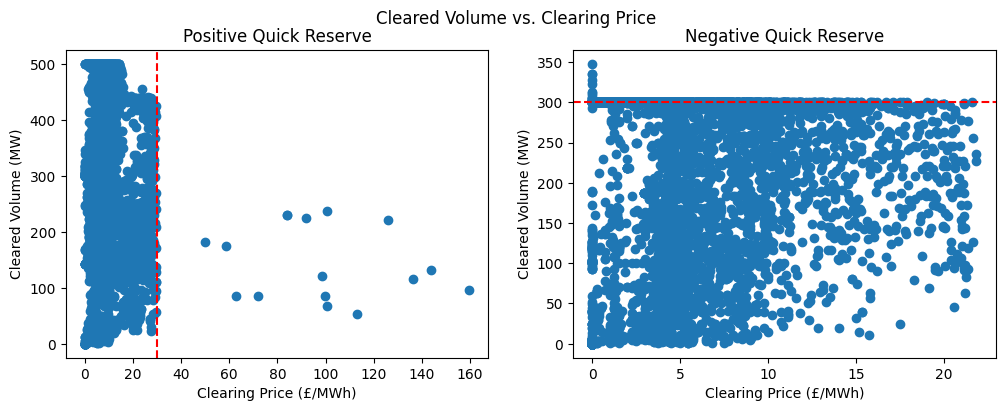

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].scatter(x= 'clearing_price', y = 'cleared_volume', data = pqr_df);
ax[0].set_xlabel('Clearing Price (£/MWh)');
ax[0].set_ylabel('Cleared Volume (MW)');
ax[0].set_title('Positive Quick Reserve');
ax[0].axvline(30, color = 'red', linestyle = '--');

ax[1].scatter(x= 'clearing_price', y = 'cleared_volume', data = nqr_df);
ax[1].set_xlabel('Clearing Price (£/MWh)');
ax[1].set_ylabel('Cleared Volume (MW)');
ax[1].set_title('Negative Quick Reserve');
ax[1].axhline(300, color = 'red', linestyle = '--');
fig.suptitle('Cleared Volume vs. Clearing Price');
# ax[0].add_line(40, )

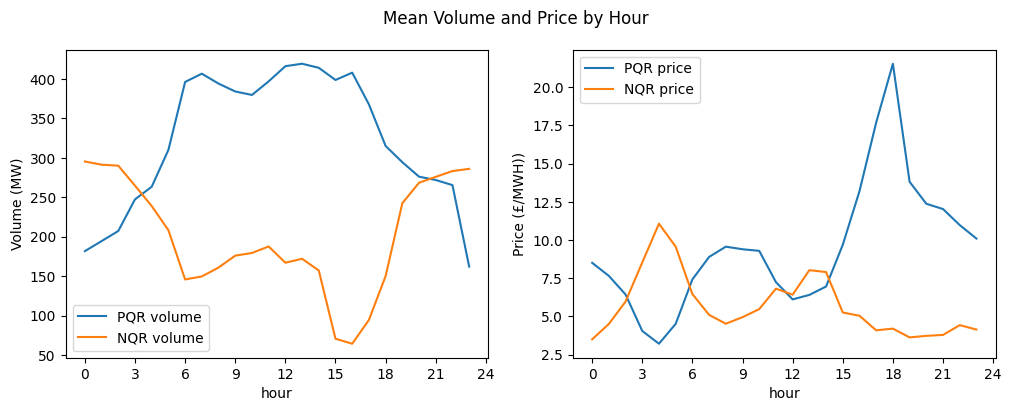

In [7]:
pqr_means = pqr_df[['hour', 'clearing_price', 'cleared_volume']].groupby('hour').mean()
nqr_means = nqr_df[['hour', 'clearing_price', 'cleared_volume']].groupby('hour').mean()
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax1, ax2= ax[0], ax[1]
hour_ticks = np.arange(0, 25, 3)
pqr_means.cleared_volume.plot(ax = ax1, label = 'PQR volume')
nqr_means.cleared_volume.plot(ax = ax1, label = 'NQR volume')
ax1.set_ylabel('Volume (MW)');
ax1.legend();
# ax1.set_title('Mean cleared volume vs. hour')
ax1.set_xticks(labels = hour_ticks, ticks=hour_ticks)

pqr_means.clearing_price.plot(ax = ax2, label = 'PQR price')
nqr_means.clearing_price.plot(ax = ax2, label = 'NQR price')
ax2.set_ylabel('Price (£/MWH))');
ax2.legend();
# ax2.set_title('Mean clearing price vs. hour');
ax2.set_xticks(labels = hour_ticks, ticks=hour_ticks);

fig.suptitle('Mean Volume and Price by Hour');


**Outcomes**

- Clearning price for positive quick response is usually between 0 to 30 £/MWh. It was above 30 £ on $10^{\text{th}}$ January and $20^{\text{th}}$ Jan 2025, reaching maximum value of 159.7 £/MWh on. Clearing price and volume are further investigated for these two days.

- The negative quick response clearing price is between 0 to 25 £/MWh. The volume is confined to 300 MW except very few occasions.

- PQR volume is higher in the day time say from 6 AM to 6 PM while NQR volume is opposite of that. Price of NQR is usually high from midnight to 6 AM while PQR price is the highest in the evening time.

#### Case I: High PQR pricing days 

$10^{\text{th}}$ and $20^{\text{th}}$ Jan 2025

In [8]:
pqr_high_cp = pqr_df[pqr_df.clearing_price>30].date.unique()
# Extracting one day data for positive quick responses
pqr_10_jan = day_df(pqr_df, '2025-01-10')
pqr_20_jan = day_df(pqr_df, '2025-01-20')

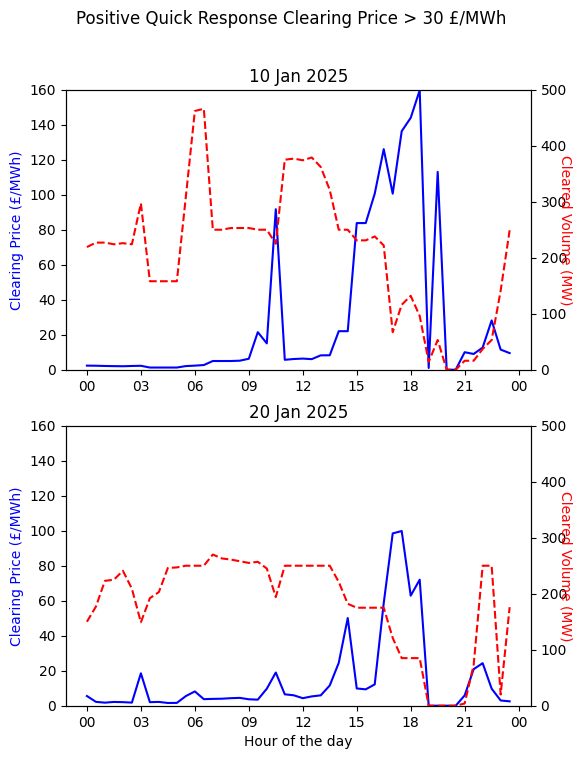

In [9]:
fig, ax = plt.subplots(2,1, figsize = (6, 8))
ax1, ax2 = ax[0], ax[1]
price_limits = [0,160]
volume_limits = [0,500]
x_var, y_left_var, y_right_var = 'delivery_start', 'clearing_price', 'cleared_volume'
y_left_label, y_right_label = 'Clearing Price (£/MWh)', 'Cleared Volume (MW)'
x_axis_format = '%H'

plot_two_variable(ax1, y_left_lim= price_limits, y_right_lim = volume_limits, 
                      x_var = x_var, y_left_var = y_left_var, y_right_var = y_right_var, 
                      y_lfet_label = y_left_label, y_right_label = y_right_label, 
                      df = pqr_10_jan,  fig_title =  '10 Jan 2025',  x_axis_format = '%H')
                     

plot_two_variable(ax2, y_left_lim= price_limits, y_right_lim = volume_limits, 
                      x_var = x_var, y_left_var = y_left_var, y_right_var = y_right_var, 
                    y_lfet_label = y_left_label, y_right_label = y_right_label, 
                    df = pqr_20_jan, fig_title =  '20 Jan 2025',x_axis_format = '%H')
                    
ax2.set_xlabel('Hour of the day');
fig.suptitle('Positive Quick Response Clearing Price > 30 £/MWh');

**Correlation of generation availabilty margin to PQR**

On $10^{\text{th}}$ January 25, clearing price was above 100 MW/h (reaching maximum of 159.7 MW/h) from 16:00 to 19:30, it was also ~90 and ~80 MWh for 10:30 and 15:00, respectively on the same day. Then, on $20^{\text{th}}$ January, the price went up high again reaching to ~100 MWh for 17:00 and 17:30. It stayed above 50 MWh for other settlement periods on the same day. 

While investigating operational margin ([NESO: Daily Operational Planning Margin Requirement ](https://www.neso.energy/data-portal/daily-opmr/daily_operational_planning_margin_requirement)), generation availability margin was negative on these days (meaning that demand was higher than genreation.)

#### Case II: NQR volume > 300 MW

$1^{\text{st}}$ and $12^{\text{th}}$ March 

Cleared volume of negative quick response is usually below 300 MW, but it has reached up to 350 MW on $12^{\text{th}}$ March at 10 AM and 335 MW on $1^{\text{st}}$ March at 1 AM. These days are investigated below:

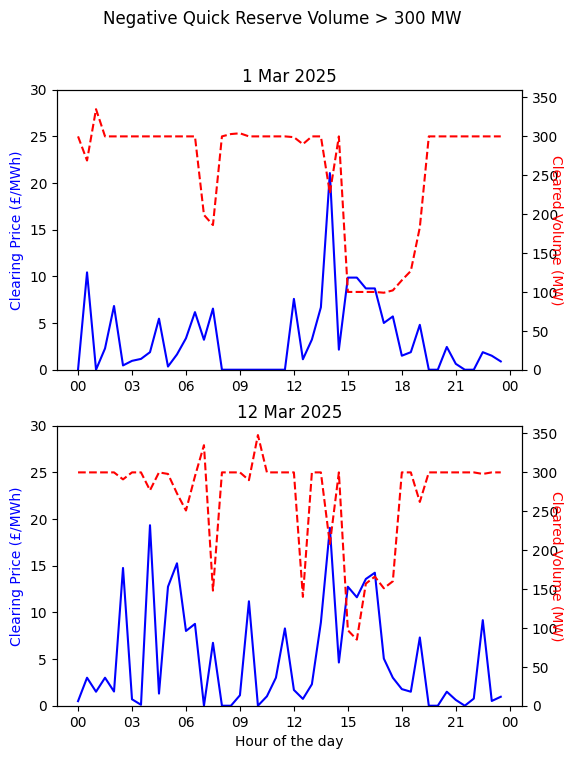

In [10]:
# nqr_df.cleared_volume.nlargest(10).sort_index()
nqr_01_mar = day_df(nqr_df, '2025-03-01')
nqr_12_mar = day_df(nqr_df, '2025-03-12')

fig, ax = plt.subplots(2,1, figsize = (6, 8))
ax1, ax2 = ax[0], ax[1]
price_limits = [0,30]
volume_limits = [0,360]
x_var, y_left_var, y_right_var = 'delivery_start', 'clearing_price', 'cleared_volume'
y_left_label, y_right_label = 'Clearing Price (£/MWh)', 'Cleared Volume (MW)'
x_axis_format = '%H'

plot_two_variable(ax1, y_left_lim= price_limits, y_right_lim = volume_limits, 
                      x_var = x_var, y_left_var = y_left_var, y_right_var = y_right_var, 
                      y_lfet_label = y_left_label, y_right_label = y_right_label, 
                      df = nqr_01_mar,  fig_title =  '1 Mar 2025',  x_axis_format = '%H')
                     

plot_two_variable(ax2, y_left_lim= price_limits, y_right_lim = volume_limits, 
                      x_var = x_var, y_left_var = y_left_var, y_right_var = y_right_var, 
                    y_lfet_label = y_left_label, y_right_label = y_right_label, 
                    df =nqr_12_mar, fig_title =  '12 Mar 2025',x_axis_format = '%H')
                    
ax2.set_xlabel('Hour of the day');
fig.suptitle('Negative Quick Reserve Volume > 300 MW');

Relevant articles:

1. [Pre-Launch from MODO](https://modoenergy.com/research/gb-battery-energy-storage-quick-reserve-balancing-mechanism-launch-november-2024)